In [97]:
import sys
import numpy as np

import matplotlib.pyplot as plt
import torch
from torchvision.datasets import MNIST

from lib.data.pseudo_corr import get_corr_samples, get_uncorr_samples

# 1. Principal Component Analysis

Principal Component Analysis (PCA) is a technique for **dimensionality reduction** of a dataset. The idea is to map a vector $x = (x_1, x_1,\ldots,x_m)$ to a lower-dimensional vector $z = (z_1,z_2,\ldots,z_n)$ with $n\lt m$. We are going to consider linear mappings here, such that

$$
z = Px
$$

with $P$ a matrix of size $m\times m$. In PCA, this matrix $P$ is composed by choosing the $n$ eigenvectors that correspond to the $n$ largest eigenvalues of the covariance matrix of the dataset. These eigenvectors indicate the directions in which the data varies the most. When we project the data onto these eigenvectors (which is exactly what we do when multiplying with matrix $P$) we will thus maximally preserve the data variability in the lower-dimensional space.

More specifically, one can use the following algorithm to perform PCA reduction:

- Calculate the $m\times m$ dimensional covariance matrix of the dataset.
- Calculate the eigenvectors and eigenvalues of this covariance matrix.
- Determine the dimension $n$ of the reduced dataset by looking at the largest eigenvalues. The quality of the reduction depends on how close the sum of the largest $n$ eigenvalues is to the sum of all $m$ eigenvalues.
- Create the $n \times m$ projection matrix $P$ from the eigenvectors corresponding to the $n$ largest eigenvalues
- Before transforming the data, we should shift its center to the origin. To do this, compute the mean of each of the $m$ dimensions and subtract these from all datapoints.
- Reduce the centered dataset by multiplying it with $P$.

Additionally, we can try to *reconstruct* our original dataset from the compressed data. We multiply the compressed data with an $m\times n$-sized matrix $Q$:

$$
\hat{x} = Qz = QPx.
$$

We choose $Q$ to be equal to the transpose of $P$, i.e., $Q = P^T$. If $n$ is chosen well, these regenerated datapoints should be fairly similar to the original datapoints, thus capturing most of the information in the dataset. Remember to shift the reconstructed data back to the original center of the dataset by adding the mean again.

## 1.1 Exercise: Redundancy and Random Data

### 1.1.1 Implement Your Own PCA Algorithm

The idea of this exercise is to write your own function that implements the PCA algorithm in PyTorch. The above algorithm can be programmed in PyTorch with the following functions:

- [`torch.cov()`](https://pytorch.org/docs/stable/generated/torch.cov.html): Calculates the sample covariance matrix of the given data. The data is expected to have shape $m\times B$, where the $m$ **rows are the features** and the $B$ **columns are the samples**.
- [`torch.linalg.eigh()`](https://pytorch.org/docs/stable/generated/torch.linalg.eigh.html): Computes the eigenvalues and eigenvectors of a symmetric matrix. One could also use [`torch.linalg.eig()`](https://pytorch.org/docs/stable/generated/torch.linalg.eig.html), but as a covariance matrix is symmetric by definition, it is better to use `torch.linalg.eigh()`, as this is optimized for symmetric matrices.
- [`torch.argsort()`](https://pytorch.org/docs/stable/generated/torch.argsort.html): Returns the indices that sort a tensor. Use the argument `descending=True` to get indices that sort in descending order.
- [`torch.matmul()`](https://pytorch.org/docs/stable/generated/torch.matmul.html): Computes the product of two matrices.

Some interesting tensor operations:

- Transpose a matrix `X`: [`X.T`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.T)
- Compute the mean of the items in a matrix `X` along a given dimension: [`X.mean()`](https://pytorch.org/docs/stable/generated/torch.Tensor.mean.html#torch.Tensor.mean)
- Compute the sum of the items in a matrix `X` along a given dimension: [`X.sum()`](https://pytorch.org/docs/stable/generated/torch.Tensor.sum.html#torch.Tensor.sum)

Make sure to keep track of the shapes of the matrices you are working with. For the functions you use, make sure you check the meaning of each dimension of the function's input. Transpose your matrices when necessary.

We'll start by **implementing a function that computes the eigenvalues and the eigenvectors of the covariance matrix of a dataset**. Complete the implementation below.

In [98]:
def eig_cov(X):
    """
    Compute the eigenvalues and -vectors of the covariance matrix of X.
    
    Args:
        X (torch.Tensor): Tensor of shape B x m where the rows (dim 0) are observations
            and the columns (dim 1) are variables.
    Returns:
        Tuple containing eigenvalues and eigenvectors with the eigenvectors in the
            columns.
    """
    # Estimate the m x m covariance matrix
    cov_mtrx = torch.cov(X.T)

    # Compute the eigenvectors and -values of the cov matrix
    eig_vals, eig_vecs = torch.linalg.eigh(cov_mtrx)

    return eig_vals, eig_vecs

To compose the transformation matrix $P$, we need the $n$ eigenvectors that correspond to the $n$ largest eigenvalues. As such, let's write a function that **takes in a set of eigenvalues and corresponding eigenvectors and sorts them in decreasing order of eigenvalues**.

In [99]:
def sort_eig(eig_vals, eig_vecs):
    """
    Sort the eigenvalues and -vectors in decreasing eigenvalue order.
    
    Args:
        eig_vals (torch.Tensor): Tensor of shape 
    """
    # Get the inidices that sort the eigenvalues from high to low
    idxs = torch.argsort(eig_vals, descending=True)

    # Sort the eigenvalues and eigenvectors using these indices
    sorted_eig_vals = eig_vals[idxs]
    sorted_eig_vecs = eig_vecs[idxs]

    return sorted_eig_vals, sorted_eig_vecs

For the PCA implementation itself, we'll write a class that computes the eigenvalues and eigenvectors of the dataset in its constructor (the `__init__()` function) and performs a PCA of this dataset for any dimension `n` in the method `run()`. **Complete the implementation below.**

In [100]:
class PCA:
    def __init__(self, X):
        """
        Args:
            X (torch.Tensor): Tensor containing the B samples that constitute
                the dataset.
        """
        self.X = X

        # Flatten all dataset samples (e.g. images) into B vectors of length m
        self.orig_shape = X.shape[1:]
        self.X_flat = X.flatten(start_dim=1).float()

        # Compute the eigenvalues and eigenvectors of X_flat
        eig_vals, eig_vecs = eig_cov(self.X_flat)

        # Sort the eigenvalues and eigenvectors according to decreasing eigenvalues
        self.eig_vals, self.eig_vecs = sort_eig(eig_vals, eig_vecs)

        # Compute the mean of all data samples
        self.X_mean = self.X_flat.mean(dim=0)[None, :]

    def run(self, n):
        # Get the n largest eigenvectors as an n x m matrix
        self.P = self.eig_vecs[:n]

        # Shift center of X to origin before transforming
        X_center = torch.sub(self.X, self.X_mean)

        # Perform dimensionality reduction
        # Think about the shapes of the matrices!
        self.Z = torch.matmul(self.P, X_center.T)

        # Reconstruct X from encodings
        X_rec = torch.matmul(self.P.T, self.Z)

        # Shift center back to original
        X_rec = torch.add(X_rec.T, self.X_mean)

        # Reshape to original shape
        self.X_rec_flat = X_rec
        self.X_rec = X_rec.unflatten(1, self.orig_shape)

Given a dataset `X` with `B` samples, we can create a PCA instance as follows:

```python
pca = PCA(X)
```

To apply PCA to the dataset with a dimensionality reduction to a dimension `n`, we call `run()` on the `pca` object:

```python
pca.run(n)
```

After that, `pca.Z` contains `B` vectors of (lower) dimension `n` and `pca.X_rec` contains `B` reconstructions of the input data.

### 1.1.2 Reduce Dimensionality of Uncorrelated Data

Use the function `get_uncorr_samples(n_samples)` to generate 500 samples of dimension 2 and reduce the samples to dimension 1 with your PCA implementation. Try to reconstruct the original data and estimate the error, e.g., by computing the root mean square of the difference between the reconstructed and the original data:

```python
((X - X_rec)**2).mean().sqrt()
```

Visualize the original data and the reconstructed data in a plot:

```python
fig, ax = plt.subplots()

ax.scatter(*X.T)
ax.scatter(*X_rec.T)
```

In [101]:
# Get the samples
input_samples = get_uncorr_samples(500)

# Perform the PCA and reduce the dimensionality from 2 to 1
pca = PCA(input_samples)
pca.run(1)

# Get the normal reconstructed samples
original_samples = pca.X
reconstructed_samples = pca.X_rec

In [102]:
# Calculate error
((original_samples - reconstructed_samples)**2).mean().sqrt()

tensor(0.6841)

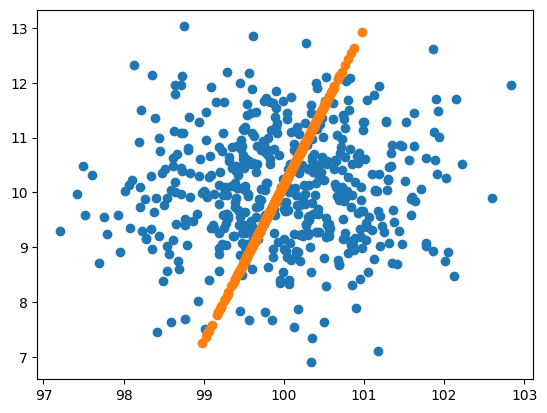

In [103]:
# Visualisation
fig, ax = plt.subplots()

ax.scatter(*original_samples.T)
ax.scatter(*reconstructed_samples.T)

### 1.1.3 Reduce Dimensionality of Correlated Data

Do the same for 500 samples returned by `get_corr_samples(n_samples)`. How does the reduction of uncorrelated data compare to the reduction of correlated data?

In [104]:
# Get the samples
input_samples_corr = get_corr_samples(500)

# Perform the PCA and reduce the dimensionality from 2 to 1
pca_corr = PCA(input_samples_corr)
pca_corr.run(1)

# Get the normal reconstructed samples
original_samples_corr = pca_corr.X
reconstructed_samples_corr = pca_corr.X_rec

In [105]:
# Calculate error
((original_samples_corr - reconstructed_samples_corr)**2).mean().sqrt()

tensor(0.0723)

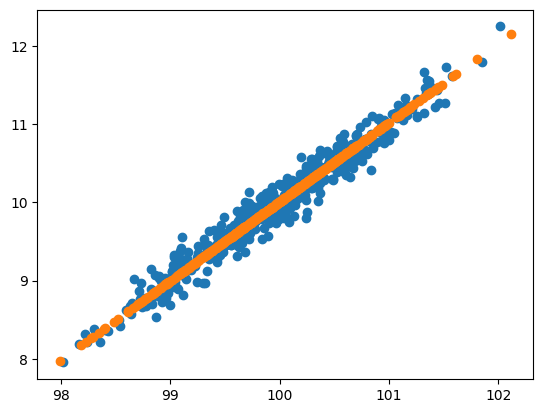

In [106]:
# Visualisation
fig, ax = plt.subplots()

ax.scatter(*original_samples_corr.T)
ax.scatter(*reconstructed_samples_corr.T)

## 1.2 Principal Component Analysis on Handwritten Digits

### 1.2.1 The MNIST Dataset

[MNIST](http://yann.lecun.com/exdb/mnist/) is a dataset containing images of handwritten digits. We can easily get the dataset using the following command:

In [107]:
mnist = MNIST(root='data', download=True)

The dataset will automatically be downloaded in a folder called `data`. The `mnist` object has an attribute `data` that contains the raw images as PyTorch tensors. For example, to show the image at index `0`, run the following cell.

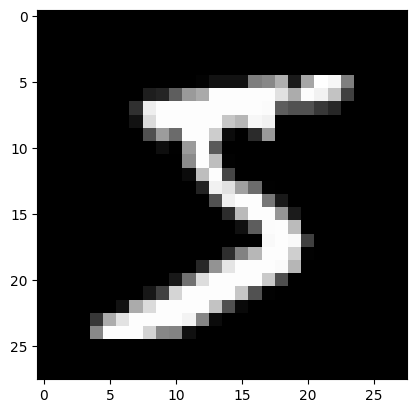

In [108]:
plt.imshow(mnist.data[0], cmap='gray')

The `cmap='gray'` argument ensures that the image is visualized in grayscale.

The `mnist` object also has an attribute `targets` that contains the label of each image in `mnist.data`. For example, with the follwing code, we can select all images that have the label `3`.

In [109]:
idxs = torch.nonzero(mnist.targets == 3).flatten()
threes = mnist.data[idxs]

Compute the mean 3 and display it.

In [110]:
## Write your code here ##
# ???

Before applying PCA, you should flatten the images such that they are all vectors and cast the values to floats. You can do this with the following line of code:

In [111]:
X = threes.flatten(start_dim=1).float()

To visualize a batch of reconstructed images `X_rec`, you'll need to reshape the images back into their original shape with `X_rec.unflatten(1, (28, 28))`.

### 1.2.2 Exercise: Apply PCA to MNIST

- Apply your PCA implementation to compress the dataset of threes by projecting it onto one, two, three and four principal components. Visualize some reconstructions of each compression.
- Compress the data now for $n \in \{1,2,\ldots, 50 \}$ and compute the reconstruction error for each value of $n$. You'll want to use a `for` loop here. Also see the built-in Python [`range()`](https://www.w3schools.com/python/ref_func_range.asp) function. Plot the reconstruction error as a function of $n$.
- What should the reconstruction error be if $n = 784$? What is it if you actually try it? Why?
- Use [`torch.cumsum()`](https://pytorch.org/docs/stable/generated/torch.cumsum.html) to create a vector whose $i$-th element is the sum of all but the $i$ largest eigenvalues with $i \in \{1,2\ldots, 784\}$. Visualize this with Matplotlib using `plt.plot()`. Compare the first 50 elements of this vector to the vector of reconstruction errors calculated previously. What do you notice?

The last question should show you a very interesting and important fact: the squared reconstruction error induced by not using a certain principal component is proportional to its eigenvalue. That is why, if the eigenvalues fall off quickly, projecting onto the first few components gives small errors.

### 1 principle component

In [112]:
# Perform the PCA and reduce the dimensionality
pca_1 = PCA(X)
pca_1.run(1)

# Get the normal reconstructed samples
original_samples_1 = pca_1.X
reconstructed_samples_1 = pca_1.X_rec

In [113]:
# Calculate error
((original_samples_1 - reconstructed_samples_1)**2).mean().sqrt()

tensor(60.9700)

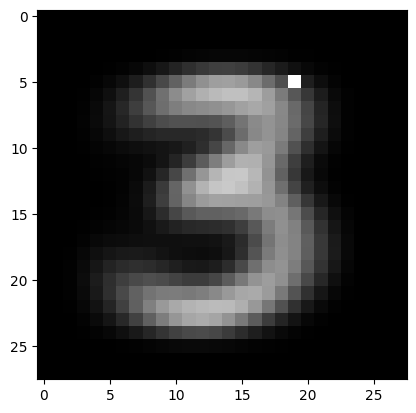

In [114]:
# Visualisation

# Get the first sample for visualization
selected_sample_1 = reconstructed_samples_1[0]

# Unflatten the image
selected_sample_1 = selected_sample_1.reshape((28, 28))

# Display
plt.imshow(selected_sample_1, cmap='gray')

### 2 principle component

In [115]:
# Perform the PCA and reduce the dimensionality
pca_2 = PCA(X)
pca_2.run(2)

# Get the normal reconstructed samples
original_samples_2 = pca_2.X
reconstructed_samples_2 = pca_2.X_rec

In [116]:
# Calculate error
((original_samples_2 - reconstructed_samples_2)**2).mean().sqrt()

tensor(60.8600)

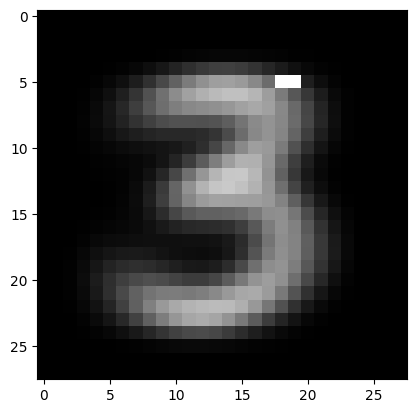

In [117]:
# Visualisation

# Get the first sample for visualization
selected_sample_2 = reconstructed_samples_2[0]

# Unflatten the image
selected_sample_2 = selected_sample_2.reshape((28, 28))

# Display
plt.imshow(selected_sample_2, cmap='gray')

### 3 principle component

In [118]:
# Perform the PCA and reduce the dimensionality
pca_3 = PCA(X)
pca_3.run(3)

# Get the normal reconstructed samples
original_samples_3 = pca_3.X
reconstructed_samples_3 = pca_3.X_rec

In [119]:
# Calculate error
((original_samples_3 - reconstructed_samples_3)**2).mean().sqrt()

tensor(60.7370)

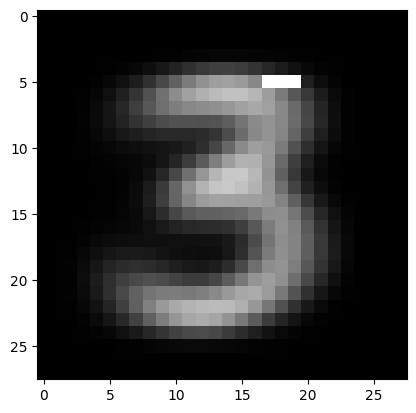

In [120]:
# Visualisation

# Get the first sample for visualization
selected_sample_3 = reconstructed_samples_3[0]

# Unflatten the image
selected_sample_3 = selected_sample_3.reshape((28, 28))

# Display
plt.imshow(selected_sample_3, cmap='gray')

### 4 principle component

In [121]:
# Perform the PCA and reduce the dimensionality
pca_4 = PCA(X)
pca_4.run(4)

# Get the normal reconstructed samples
original_samples_4 = pca_4.X
reconstructed_samples_4 = pca_4.X_rec

In [122]:
# Calculate error
((original_samples_4 - reconstructed_samples_4)**2).mean().sqrt()

tensor(60.6134)

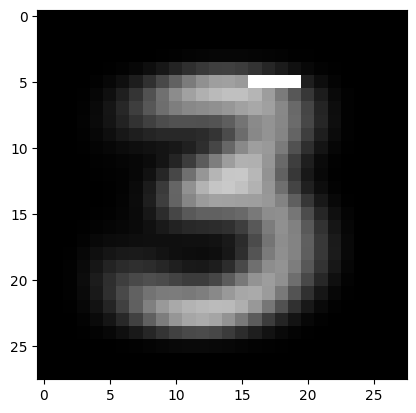

In [123]:
# Visualisation

# Get the first sample for visualization
selected_sample_4 = reconstructed_samples_4[0]

# Unflatten the image
selected_sample_4 = selected_sample_4.reshape((28, 28))

# Display
plt.imshow(selected_sample_4, cmap='gray')

### 1 to 50 principal components

In [124]:
p_components =[]
loss_values = []

for i in range(1,50):
    # Perform the PCA and reduce the dimensionality
    pca_loop = PCA(X)
    pca_loop.run(i)

    # Get the normal reconstructed samples
    original_samples_loop = pca_loop.X
    reconstructed_samples_loop = pca_loop.X_rec

    # Calculate error
    loss = ((original_samples_loop - reconstructed_samples_loop)**2).mean().sqrt()

    # Store results
    p_components.append(i)
    loss_values.append(loss.item())

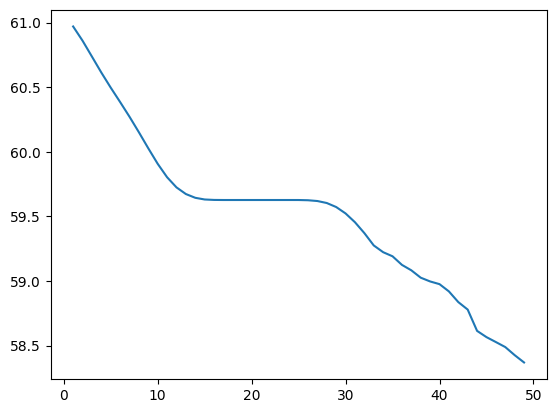

In [125]:
# Plot the results
fig, ax = plt.subplots()

ax.plot(p_components, loss_values)

### Sum eigenvalues

In [126]:
# Compute the eigenvalues and eigenvectors of data
eig_vals, eig_vecs = eig_cov(X)

# Get the inidices that sort the eigenvalues from low to high
idxs = torch.argsort(eig_vals, descending=False)

# Sort the eigenvalues and eigenvectors using these indices
sorted_eig_vals = eig_vals[idxs]
sorted_eig_vecs = eig_vecs[idxs]

In [127]:
# Calculate the cumulative sum
cum_sum = torch.cumsum(sorted_eig_vals, dim=0)

nr_of_left_out = np.arange(0,784,1,dtype=int)[::-1]
eig_values_sum = cum_sum.numpy()

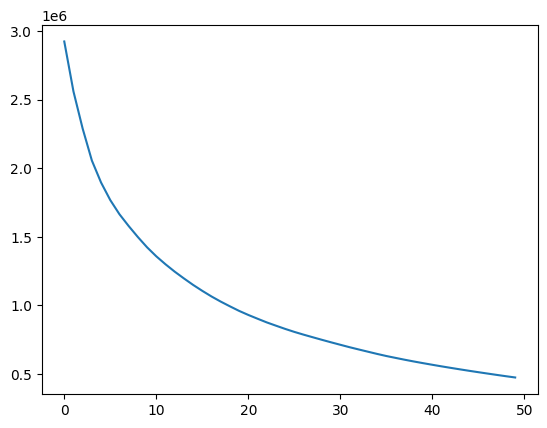

In [128]:
# Plot the results
fig, ax = plt.subplots()

ax.plot(nr_of_left_out[-50:], eig_values_sum[-50:])